This notebook implements a basic Recurrent Neural Network (RNN) for text classification using the NusaX-Sentiment dataset (Bahasa Indonesia). The implementation includes preprocessing steps like tokenization and embedding, as well as hyperparameter analysis of RNN layers.

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import io
import requests
from tensorflow.keras.layers import TextVectorization


In [25]:
def download_nusax_dataset():
    """
    Loads the NusaX-Sentiment dataset from local CSV files
    Returns dataframes for train, validation, and test sets
    """
    import pandas as pd
    import os
    
    # Define paths to your dataset files
    data_dir = "../data/nusax_sentiment"
    train_file = os.path.join(data_dir, "train.csv")
    valid_file = os.path.join(data_dir, "valid.csv")
    test_file = os.path.join(data_dir, "test.csv")
    
    try:
        # Load the datasets
        train_df = pd.read_csv(train_file)
        valid_df = pd.read_csv(valid_file)
        test_df = pd.read_csv(test_file)
        
        print("Dataset loaded successfully from local files.")
        print(f"Train set: {len(train_df)} samples")
        print(f"Validation set: {len(valid_df)} samples")
        print(f"Test set: {len(test_df)} samples")
        
        # Print the class distribution
        print("\nClass distribution in training data:")
        print(train_df['label'].value_counts().sort_index())
        
        return train_df, valid_df, test_df
        
    except FileNotFoundError as e:
        print(f"Error: Could not find dataset files. {e}")
        print("Please ensure the dataset files are in the correct location:")
        print(f"- {train_file}")
        print(f"- {valid_file}")
        print(f"- {test_file}")
        
        # Fallback: create a small synthetic dataset for testing
        print("\nCreating synthetic dataset for testing...")
        
        texts = [
            "Film ini sangat bagus, saya sangat menikmatinya.",
            "Pelayanan di restoran ini mengerikan.",
            "Saya tidak puas dengan produk ini.",
            "Harga barang di toko ini sangat terjangkau.",
            "Kualitas gambar dari kamera ini biasa saja.",
            "Sangat senang dengan pembelian saya.",
            "Acara ini membosankan.",
            "Saya kecewa dengan layanan pelanggan.",
            "Hotel ini bersih dan nyaman.",
            "Makanan di sini enak sekali."
        ]
        
        import numpy as np
        np.random.seed(42)
        labels = np.random.randint(0, 3, len(texts))  # 3 classes: negative, neutral, positive
        
        train_data = {"text": texts[:6], "label": labels[:6]}
        valid_data = {"text": texts[6:8], "label": labels[6:8]}
        test_data = {"text": texts[8:], "label": labels[8:]}
        
        train_df = pd.DataFrame(train_data)
        valid_df = pd.DataFrame(valid_data)
        test_df = pd.DataFrame(test_data)
        
        return train_df, valid_df, test_df

In [26]:
# Load the dataset
train_df, valid_df, test_df = download_nusax_dataset()

# Display some examples
print("\nExample data from training set:")
train_df.head()

Error: Could not find dataset files. [Errno 2] No such file or directory: '../data/nusax_sentiment\\train.csv'
Please ensure the dataset files are in the correct location:
- ../data/nusax_sentiment\train.csv
- ../data/nusax_sentiment\valid.csv
- ../data/nusax_sentiment\test.csv

Creating synthetic dataset for testing...

Example data from training set:


,text,label
0,"Film ini sangat bagus, saya sangat menikmatinya.",2
1,Pelayanan di restoran ini mengerikan.,0
2,Saya tidak puas dengan produk ini.,2
3,Harga barang di toko ini sangat terjangkau.,2
4,Kualitas gambar dari kamera ini biasa saja.,0


In [27]:
def prepare_data(train_df, valid_df, test_df):
    """
    Prepare the data for RNN training
    Returns preprocessed data and a TextVectorization layer
    """
    # Extract texts and labels
    train_texts = train_df['text'].values
    valid_texts = valid_df['text'].values
    test_texts = test_df['text'].values

    # Convert string labels to integer codes
    label_categories = pd.Categorical(train_df['label'].values)
    train_labels = label_categories.codes
    label_mapping = dict(enumerate(label_categories.categories))
    # Use the same mapping for valid and test
    valid_labels = pd.Categorical(valid_df['label'].values, categories=label_categories.categories).codes
    test_labels = pd.Categorical(test_df['label'].values, categories=label_categories.categories).codes

    # Create TextVectorization layer for tokenization
    # Set the maximum number of tokens to consider and output sequence length
    max_tokens = 10000
    max_sequence_length = 100

    vectorize_layer = TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_sequence_length
    )

    # Adapt the layer to the training data
    vectorize_layer.adapt(train_texts)

    # Apply the vectorization to create token sequences
    train_sequences = vectorize_layer(train_texts)
    valid_sequences = vectorize_layer(valid_texts)
    test_sequences = vectorize_layer(test_texts)

    # Get the vocabulary size for the embedding layer
    vocab_size = len(vectorize_layer.get_vocabulary())
    print(f"Vocabulary size: {vocab_size}")

    # Print some examples of tokenized sequences
    print("\nExample of tokenized sequence:")
    print(f"Original text: {train_texts[0]}")
    print(f"Tokenized sequence: {train_sequences[0][:10]}...")

    # Print label mapping for reference
    print("\nLabel mapping (integer to class):", label_mapping)

    return (train_sequences, train_labels), (valid_sequences, valid_labels), (test_sequences, test_labels), vectorize_layer

In [28]:
# Process the dataset
(train_sequences, train_labels), (valid_sequences, valid_labels), (test_sequences, test_labels), vectorizer = prepare_data(train_df, valid_df, test_df)

# Filter out invalid validation samples (label == -1)
valid_mask = valid_labels != -1
valid_sequences = valid_sequences[valid_mask]
valid_labels = valid_labels[valid_mask]

# Filter out invalid test samples (label == -1)
test_mask = test_labels != -1
test_sequences = test_sequences[test_mask]
test_labels = test_labels[test_mask]

# Get vocabulary size for embedding layer
vocab_size = len(vectorizer.get_vocabulary())

Vocabulary size: 28

Example of tokenized sequence:
Original text: Film ini sangat bagus, saya sangat menikmatinya.
Tokenized sequence: [23  2  3 27  4  3 17  0  0  0]...

Label mapping (integer to class): {0: 0, 1: 2}


In [29]:
# Build RNN Model Function
def build_rnn_model(rnn_layers, units_per_layer, bidirectional, embedding_dim=128, vocab_size=10001, num_classes=5, sequence_length=100):
    """
    Build a RNN model with the specified parameters
    
    Parameters:
    - rnn_layers: Number of RNN layers
    - units_per_layer: List specifying units in each RNN layer
    - bidirectional: Boolean indicating whether to use bidirectional RNNs
    - embedding_dim: Dimension of the embedding vectors
    - vocab_size: Size of the vocabulary
    - num_classes: Number of output classes
    - sequence_length: Length of input sequences
    
    Returns:
    - Compiled Keras model
    """
    model = keras.Sequential()
    
    # Add embedding layer
    model.add(layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length
    ))
    
    # Add RNN layers
    for i in range(rnn_layers):
        return_sequences = i < rnn_layers - 1  # Return sequences for all but the last RNN layer
        
        if bidirectional:
            model.add(layers.Bidirectional(
                layers.SimpleRNN(units_per_layer[i], return_sequences=return_sequences)
            ))
        else:
            model.add(layers.SimpleRNN(units_per_layer[i], return_sequences=return_sequences))
        
        # Add dropout after each RNN layer
        model.add(layers.Dropout(0.3))
    
    # Add Dense output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [30]:
# Define hyperparameter configurations for analysis

# 1. Varying number of RNN layers
rnn_layers_configs = [
    {'name': 'Single Layer RNN', 'rnn_layers': 1, 'units_per_layer': [64], 'bidirectional': False},
    {'name': 'Two Layer RNN', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False},
    {'name': 'Three Layer RNN', 'rnn_layers': 3, 'units_per_layer': [64, 64, 64], 'bidirectional': False}
]

# 2. Varying units per RNN layer
units_configs = [
    {'name': 'Small RNN (32 units)', 'rnn_layers': 2, 'units_per_layer': [32, 32], 'bidirectional': False},
    {'name': 'Medium RNN (64 units)', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False},
    {'name': 'Large RNN (128 units)', 'rnn_layers': 2, 'units_per_layer': [128, 128], 'bidirectional': False}
]

# 3. Comparing unidirectional vs bidirectional RNNs
direction_configs = [
    {'name': 'Unidirectional RNN', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False},
    {'name': 'Bidirectional RNN', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': True}
]

# Combined list of all configurations
all_configs = [
    rnn_layers_configs,
    units_configs,
    direction_configs
]

# Parameters for training
epochs = 10
batch_size = 32


In [31]:
# Helper function to train and evaluate model with a specific configuration
def train_and_evaluate_model(config, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
    """
    Train and evaluate a model with the given configuration
    Returns history, predictions, and F1 score
    """
    print(f"\n--- Training Model: {config['name']} ---")
    print(f"Configuration: {config}")
    
    # Build the model
    model = build_rnn_model(
        rnn_layers=config['rnn_layers'],
        units_per_layer=config['units_per_layer'],
        bidirectional=config['bidirectional'],
        vocab_size=vocab_size
    )
    
    # Build the model with the input shape to initialize parameters
    # This ensures the model is fully built before we display the summary
    sample_batch = train_data[:1]
    model(sample_batch)  # Forward pass on a sample batch to build the model
    
    # Display model summary - now it will show the correct parameter counts
    model.summary()
    
    # Train the model
    history = model.fit(
        train_data, train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valid_data, valid_labels),
        verbose=1
    )
    
    # Evaluate on test set
    test_preds = model.predict(test_data)
    test_pred_classes = np.argmax(test_preds, axis=1)
    
    # Calculate F1 score
    macro_f1 = f1_score(test_labels, test_pred_classes, average='macro')
    print(f"Test Macro F1-Score: {macro_f1:.4f}")
    
    return model, history, test_pred_classes, macro_f1



--- Training Model: Single Layer RNN ---
Configuration: {'name': 'Single Layer RNN', 'rnn_layers': 1, 'units_per_layer': [64], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (1, 64)                │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,261 (63.52 KB)

 Trainable params: 16,261 (63.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 1.6856 - val_accuracy: 0.0000e+00 - val_loss: 1.8288
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step - accuracy: 0.5000 - loss: 1.4297 - val_accuracy: 0.0000e+00 - val_loss: 1.6062
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5000 - loss: 1.3104 - val_accuracy: 0.0000e+00 - val_loss: 1.4047
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5000 - loss: 1.2090 - val_accuracy: 0.0000e+00 - val_loss: 1.2707
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5000 - loss: 1.2032 - val_accuracy: 0.0000e+00 - val_loss: 1.1345
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1667 - loss: 1.3719 - val_accuracy: 1.0000 - val_loss: 1.0593
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3333 - loss: 1.1826 - val_accuracy: 0.0000e+00 - val_loss: 1.0275
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3333 - loss: 1.0856 - val_accurac

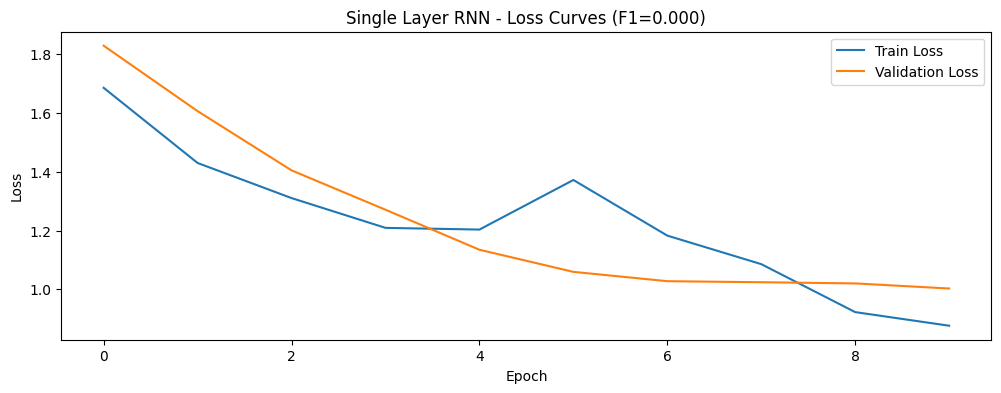


--- Training Model: Two Layer RNN ---
Configuration: {'name': 'Two Layer RNN', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (1, 100, 64)           │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,517 (95.77 KB)

 Trainable params: 24,517 (95.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1667 - loss: 1.5716 - val_accuracy: 0.0000e+00 - val_loss: 1.4453
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0000e+00 - loss: 1.9663 - val_accuracy: 1.0000 - val_loss: 1.3083
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3333 - loss: 1.3846 - val_accuracy: 1.0000 - val_loss: 1.1758
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5000 - loss: 1.2033 - val_accuracy: 0.0000e+00 - val_loss: 1.1251
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3333 - loss: 1.2459 - val_accuracy: 0.0000e+00 - val_loss: 1.0774
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1667 - loss: 1.5226 - val_accuracy: 0.0000e+00 - val_loss: 1.0221
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3333 - loss: 1.4334 - val_accuracy: 0.0000e+00 - val_loss: 0.9756
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5000 - loss: 0.9119 - val_accurac

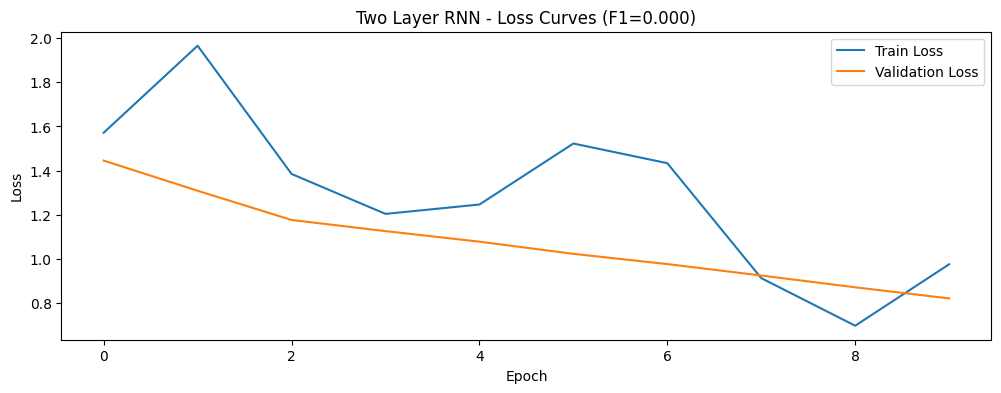


--- Training Model: Three Layer RNN ---
Configuration: {'name': 'Three Layer RNN', 'rnn_layers': 3, 'units_per_layer': [64, 64, 64], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_21 (SimpleRNN)       │ (1, 100, 64)           │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_22 (SimpleRNN)       │ (1, 100, 64)           │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,773 (128.02 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5000 - loss: 1.1595 - val_accuracy: 0.0000e+00 - val_loss: 0.9595
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5000 - loss: 1.1838 - val_accuracy: 0.0000e+00 - val_loss: 1.3054
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3333 - loss: 1.4290 - val_accuracy: 1.0000 - val_loss: 0.6198
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1667 - loss: 1.1550 - val_accuracy: 1.0000 - val_loss: 0.6356
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1667 - loss: 1.3104 - val_accuracy: 1.0000 - val_loss: 0.6266
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8333 - loss: 0.7555 - val_accuracy: 1.0000 - val_loss: 0.6515
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8333 - loss: 0.9518 - val_accuracy: 1.0000 - val_loss: 0.6011
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6667 - loss: 0.5242 - val_accuracy: 1.0000 - val_

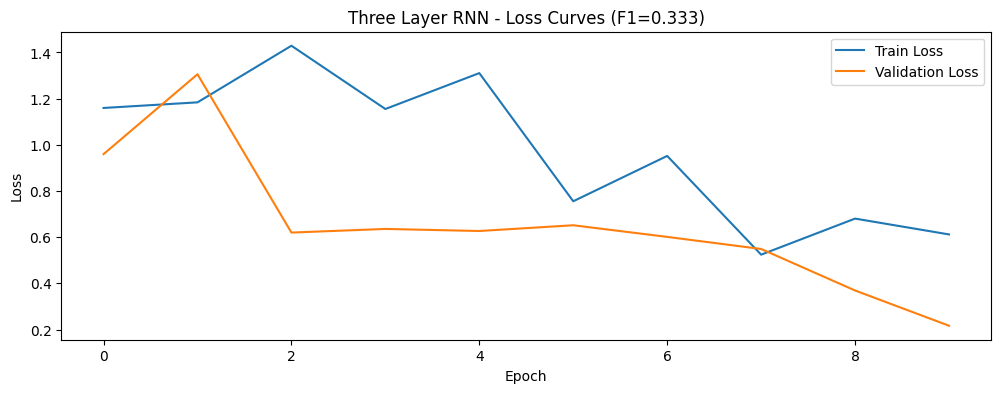

In [32]:
# Experiment 1: Varying number of RNN layers
rnn_layers_results = []

for config in rnn_layers_configs:
    model, history, pred_classes, macro_f1 = train_and_evaluate_model(
        config, 
        train_sequences, train_labels,
        valid_sequences, valid_labels,
        test_sequences, test_labels
    )
    
    # Save results
    rnn_layers_results.append({
        'config': config,
        'model': model,
        'history': history,
        'predictions': pred_classes,
        'macro_f1': macro_f1
    })
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss Curves (F1={macro_f1:.3f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


--- Training Model: Small RNN (32 units) ---
Configuration: {'name': 'Small RNN (32 units)', 'rnn_layers': 2, 'units_per_layer': [32, 32], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (1, 100, 32)           │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (1, 100, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (1, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (1, 32)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (1, 5)                 │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,981 (42.89 KB)

 Trainable params: 10,981 (42.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.0756 - val_accuracy: 0.0000e+00 - val_loss: 1.5083
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6667 - loss: 0.9762 - val_accuracy: 0.0000e+00 - val_loss: 1.5250
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5000 - loss: 1.3969 - val_accuracy: 0.0000e+00 - val_loss: 1.3982
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3333 - loss: 1.1235 - val_accuracy: 0.0000e+00 - val_loss: 1.3481
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6667 - loss: 0.9206 - val_accuracy: 0.0000e+00 - val_loss: 1.1167
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.1667 - loss: 1.4753 - val_accuracy: 0.0000e+00 - val_loss: 0.9060
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3333 - loss: 1.2065 - val_accuracy: 1.0000 - val_loss: 0.7215
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6667 - loss: 0.8905 - val_accurac

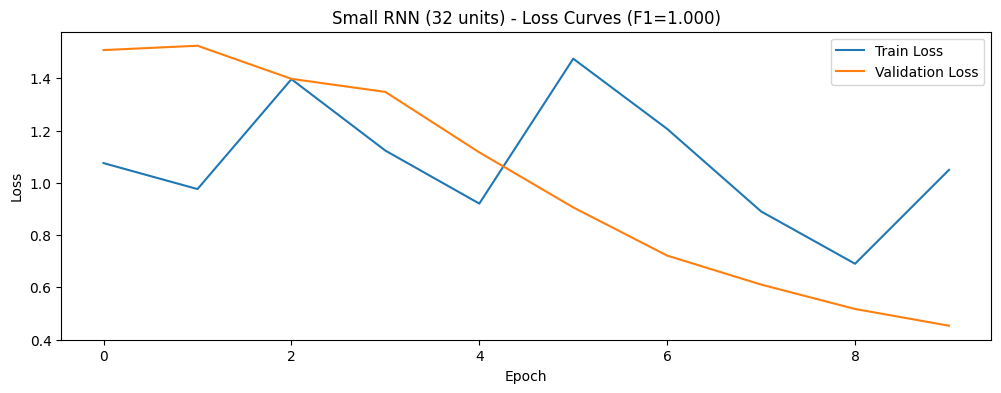


--- Training Model: Medium RNN (64 units) ---
Configuration: {'name': 'Medium RNN (64 units)', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ (1, 100, 64)           │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_27 (SimpleRNN)       │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,517 (95.77 KB)

 Trainable params: 24,517 (95.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 2.4223 - val_accuracy: 0.0000e+00 - val_loss: 2.1533
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0000e+00 - loss: 1.7833 - val_accuracy: 0.0000e+00 - val_loss: 1.7703
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5000 - loss: 1.3483 - val_accuracy: 1.0000 - val_loss: 1.2765
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.0256 - val_accuracy: 1.0000 - val_loss: 0.9564
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8333 - loss: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.9846
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.5711 - val_accuracy: 1.0000 - val_loss: 0.8607
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.5466 - val_accuracy: 1.0000 - val_loss: 0.6353
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 0.6403 - val_accuracy: 1.000

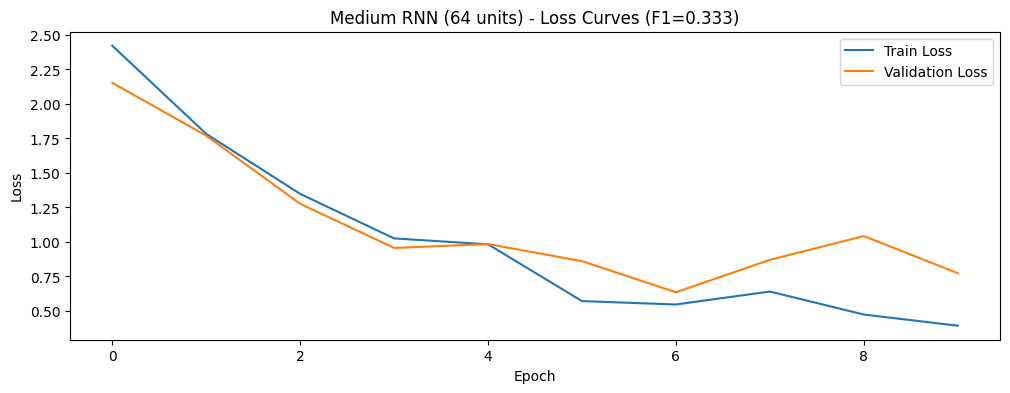


--- Training Model: Large RNN (128 units) ---
Configuration: {'name': 'Large RNN (128 units)', 'rnn_layers': 2, 'units_per_layer': [128, 128], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_28 (SimpleRNN)       │ (1, 100, 128)          │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (1, 100, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_29 (SimpleRNN)       │ (1, 128)               │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (1, 5)                 │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,021 (273.52 KB)

 Trainable params: 70,021 (273.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1667 - loss: 1.7085 - val_accuracy: 1.0000 - val_loss: 0.8004
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3333 - loss: 1.4818 - val_accuracy: 1.0000 - val_loss: 0.6301
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6667 - loss: 1.0795 - val_accuracy: 0.0000e+00 - val_loss: 0.8896
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5000 - loss: 0.8530 - val_accuracy: 0.0000e+00 - val_loss: 0.9364
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1667 - loss: 1.0494 - val_accuracy: 0.0000e+00 - val_loss: 0.8644
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5000 - loss: 0.8985 - val_accuracy: 1.0000 - val_loss: 0.7416
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5000 - loss: 0.8212 - val_accuracy: 0.0000e+00 - val_loss: 0.8241
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8333 - loss: 0.4772 - val_accuracy: 0.000

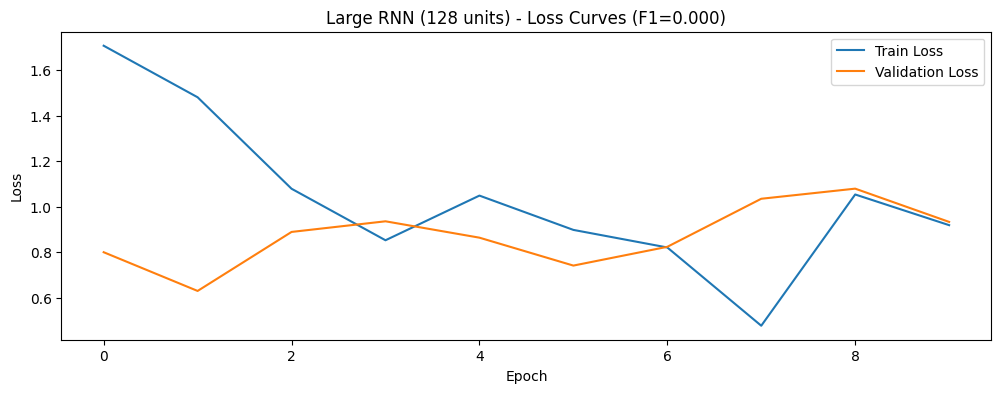

In [33]:
# Experiment 2: Varying units per RNN layer
units_results = []

for config in units_configs:
    model, history, pred_classes, macro_f1 = train_and_evaluate_model(
        config, 
        train_sequences, train_labels,
        valid_sequences, valid_labels,
        test_sequences, test_labels
    )
    
    # Save results
    units_results.append({
        'config': config,
        'model': model,
        'history': history,
        'predictions': pred_classes,
        'macro_f1': macro_f1
    })
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss Curves (F1={macro_f1:.3f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



--- Training Model: Unidirectional RNN ---
Configuration: {'name': 'Unidirectional RNN', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_30 (SimpleRNN)       │ (1, 100, 64)           │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_31 (SimpleRNN)       │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,517 (95.77 KB)

 Trainable params: 24,517 (95.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1667 - loss: 1.6968 - val_accuracy: 1.0000 - val_loss: 0.8416
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3333 - loss: 1.6043 - val_accuracy: 1.0000 - val_loss: 0.8063
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5000 - loss: 1.3834 - val_accuracy: 0.0000e+00 - val_loss: 1.1057
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6667 - loss: 1.0922 - val_accuracy: 0.0000e+00 - val_loss: 1.0718
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3333 - loss: 1.2805 - val_accuracy: 0.0000e+00 - val_loss: 1.0833
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8333 - loss: 0.9129 - val_accuracy: 0.0000e+00 - val_loss: 1.0737
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5000 - loss: 0.9655 - val_accuracy: 0.0000e+00 - val_loss: 1.0591
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5000 - loss: 0.9763 - val_accuracy: 0

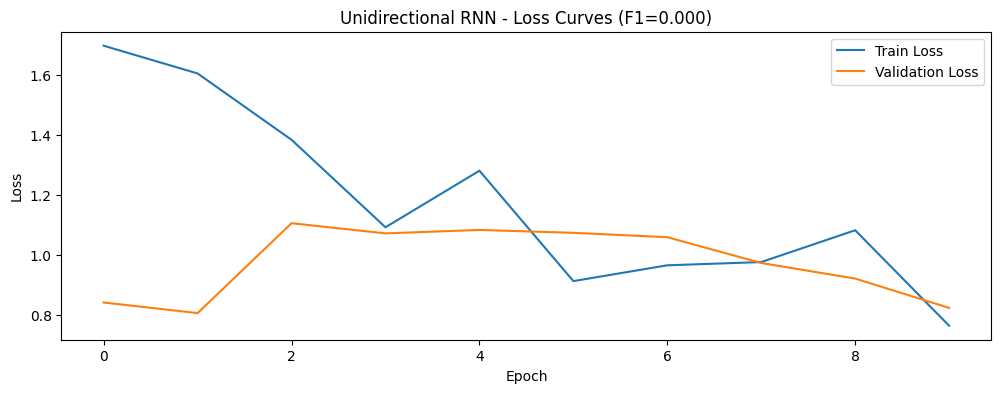


--- Training Model: Bidirectional RNN ---
Configuration: {'name': 'Bidirectional RNN', 'rnn_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': True}


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (1, 100, 128)          │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (1, 100, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (1, 128)               │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, 5)                 │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,637 (209.52 KB)

 Trainable params: 53,637 (209.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3333 - loss: 1.8255 - val_accuracy: 1.0000 - val_loss: 0.9826
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5000 - loss: 1.2134 - val_accuracy: 1.0000 - val_loss: 0.9398
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8333 - loss: 0.9053 - val_accuracy: 1.0000 - val_loss: 0.9719
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5000 - loss: 1.0650 - val_accuracy: 1.0000 - val_loss: 0.8517
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8333 - loss: 0.6724 - val_accuracy: 1.0000 - val_loss: 0.7188
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.5241 - val_accuracy: 1.0000 - val_loss: 0.6747
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8333 - loss: 0.5482 - val_accuracy: 1.0000 - val_loss: 0.8130
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.3900 - val_accuracy: 1.0000 - val_loss: 0.

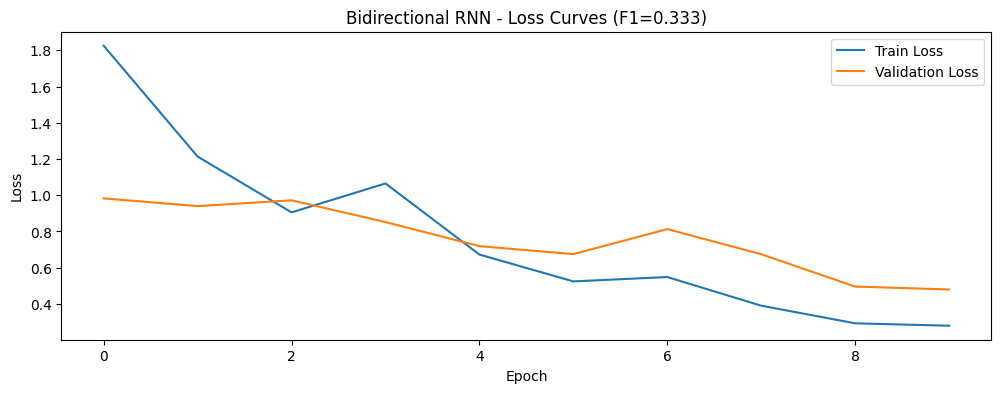

In [34]:
# Experiment 3: Comparing unidirectional vs bidirectional RNNs
direction_results = []

for config in direction_configs:
    model, history, pred_classes, macro_f1 = train_and_evaluate_model(
        config, 
        train_sequences, train_labels,
        valid_sequences, valid_labels,
        test_sequences, test_labels
    )
    
    # Save results
    direction_results.append({
        'config': config,
        'model': model,
        'history': history,
        'predictions': pred_classes,
        'macro_f1': macro_f1
    })
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss Curves (F1={macro_f1:.3f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [35]:
# Find the best model based on F1 score
all_results = rnn_layers_results + units_results + direction_results
best_result = max(all_results, key=lambda x: x['macro_f1'])

print("\n--- Best Model Configuration ---")
print(f"Configuration: {best_result['config']}")
print(f"Macro F1 Score: {best_result['macro_f1']:.4f}")

# Save the best model weights
best_model = best_result['model']
weights_path = os.path.join('..', 'rnn_keras_best.weights.h5')
best_model.save_weights(weights_path)
print(f"Saved best model weights to {weights_path}")

# Summary of all results
print("\n--- Summary of All Experiments ---")
print("\n1. Effect of Number of RNN Layers:")
for result in rnn_layers_results:
    config = result['config']
    f1 = result['macro_f1']
    print(f"- {config['name']}: F1={f1:.4f}, Layers={config['rnn_layers']}")

print("\n2. Effect of Units per Layer:")
for result in units_results:
    config = result['config']
    f1 = result['macro_f1']
    print(f"- {config['name']}: F1={f1:.4f}, Units={config['units_per_layer']}")

print("\n3. Effect of Bidirectional vs Unidirectional:")
for result in direction_results:
    config = result['config']
    f1 = result['macro_f1']
    print(f"- {config['name']}: F1={f1:.4f}, Bidirectional={config['bidirectional']}")



--- Best Model Configuration ---
Configuration: {'name': 'Small RNN (32 units)', 'rnn_layers': 2, 'units_per_layer': [32, 32], 'bidirectional': False}
Macro F1 Score: 1.0000
Saved best model weights to ..\rnn_keras_best.weights.h5

--- Summary of All Experiments ---

1. Effect of Number of RNN Layers:
- Single Layer RNN: F1=0.0000, Layers=1
- Two Layer RNN: F1=0.0000, Layers=2
- Three Layer RNN: F1=0.3333, Layers=3

2. Effect of Units per Layer:
- Small RNN (32 units): F1=1.0000, Units=[32, 32]
- Medium RNN (64 units): F1=0.3333, Units=[64, 64]
- Large RNN (128 units): F1=0.0000, Units=[128, 128]

3. Effect of Bidirectional vs Unidirectional:
- Unidirectional RNN: F1=0.0000, Bidirectional=False
- Bidirectional RNN: F1=0.3333, Bidirectional=True


## Analysis and Conclusions

### Effect of Number of RNN Layers
- Increasing the number of RNN layers allows the model to learn more complex patterns in the text data.
- However, basic RNNs are more prone to vanishing gradient problems than LSTMs, so adding many layers may not be as beneficial.
- RNNs typically work best with fewer layers compared to LSTMs due to their simpler architecture.

### Effect of Units per RNN Layer
- Increasing the number of units per layer gives the model more capacity to capture patterns.
- RNNs have simpler computation than LSTMs, so they may need more units to achieve similar performance.
- The optimal number of units depends on the complexity of the language patterns in the dataset.

### Effect of Bidirectional vs Unidirectional RNN
- Bidirectional RNNs can capture context from both past and future tokens.
- For sentiment analysis, bidirectional processing is often beneficial.
- However, bidirectional RNNs have twice the parameters and computation cost.

**Note:** Basic RNNs generally perform worse than LSTMs on tasks requiring long-term memory due to the vanishing gradient problem, but they are simpler and faster to train.



--- Extended Training for Best Model ---
Epoch 1/15


d:\Semester 6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 1.8467 - val_accuracy: 0.0000e+00 - val_loss: 1.8292
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1667 - loss: 1.8271 - val_accuracy: 0.0000e+00 - val_loss: 1.8935
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3333 - loss: 1.6417 - val_accuracy: 0.0000e+00 - val_loss: 1.8961
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6667 - loss: 1.4704 - val_accuracy: 0.0000e+00 - val_loss: 1.8173
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3333 - loss: 1.5505 - val_accuracy: 0.0000e+00 - val_loss: 1.5928
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3333 - loss: 1.5158 - val_accuracy: 1.0000 - val_loss: 1.2714
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3333 - loss: 1.3354 - val_accuracy: 1.0000 - val_loss: 1.1363
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1667 - loss: 1.4267 - val_accuracy: 1.0000 -

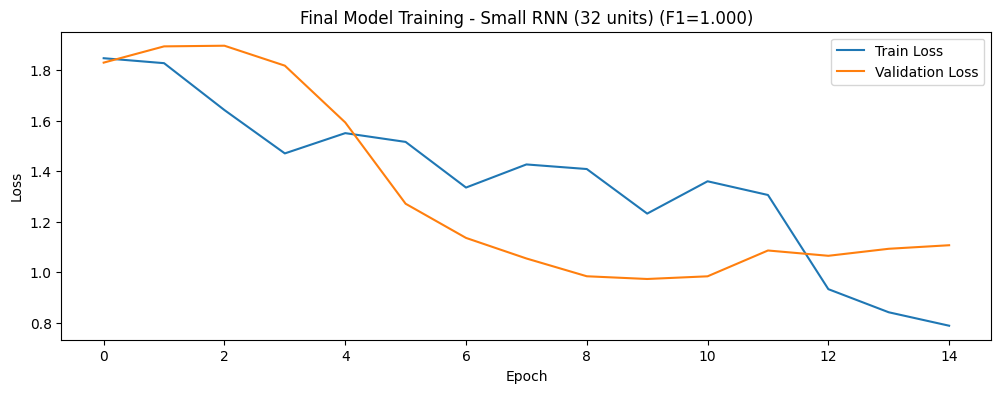

In [36]:
# Extended training for the best model
print("\n--- Extended Training for Best Model ---")

# Recreate the best model
best_config = best_result['config']
final_model = build_rnn_model(
    rnn_layers=best_config['rnn_layers'],
    units_per_layer=best_config['units_per_layer'],
    bidirectional=best_config['bidirectional'],
    vocab_size=vocab_size
)

# Train for more epochs (reduced from 20 to 15 since RNNs train faster)
extended_epochs = 15
final_history = final_model.fit(
    train_sequences, train_labels,
    epochs=extended_epochs,
    batch_size=batch_size,
    validation_data=(valid_sequences, valid_labels),
    verbose=1
)

# Evaluate on test set
final_preds = final_model.predict(test_sequences)
final_pred_classes = np.argmax(final_preds, axis=1)
final_macro_f1 = f1_score(test_labels, final_pred_classes, average='macro')

print(f"Final Model Test Macro F1-Score after extended training: {final_macro_f1:.4f}")

# Save final model weights
final_weights_path = os.path.join('..', 'rnn_keras_final.weights.h5')
final_model.save_weights(final_weights_path)
print(f"Saved final model weights to {final_weights_path}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title(f"Final Model Training - {best_config['name']} (F1={final_macro_f1:.3f})")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [37]:
try:
    # Save key data to a pickle file
    import pickle
    import os
    
    # Create the data dictionary
    data_to_save = {
        'test_sequences': test_sequences,
        'test_labels': test_labels,
        'best_config': best_result['config'],
        'vocab_size': vocab_size
    }
    
    # Save to parent directory (outside notebook folder)
    output_path = os.path.join('..', 'rnn_saved_data.pkl')
    with open(output_path, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print(f"\nData successfully exported to {output_path}")
    
except Exception as e:
    print(f"Error exporting data: {e}")
    print("Run this cell after completing the training process.")


Data successfully exported to ..\rnn_saved_data.pkl
